# Data Ball Z
# Clustering Analysis of Health News in Twitter Dataset
___

# Preamble

In [31]:
# Relevant imports

import re
import string
import glob
import numpy as np
import pandas as pd
import sys
import contractions
import seaborn as sns
from nltk.corpus import stopwords
from datetime import datetime
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
import scipy.cluster.hierarchy as shc

## Data Exploration

In [2]:
# Loading in the data

# Get text files list from a folder and creating a dataframe
txt_files = glob.glob("./Health-Tweets/*.txt")

print(f"There are a total of {len(txt_files)} files that compose the dataset.")

There are a total of 16 files that compose the dataset.


In [3]:
# Creating a DataFrame from the multiple text files

tweet_df = pd.DataFrame({'id': pd.Series(dtype='str'),
                   'datetime': pd.Series(dtype='str'),
                   'tweet': pd.Series(dtype='str')})


for txt in txt_files:
    f = open(txt, 'r', encoding='ISO-8859-1')
    lines = f.readlines()
    f.close()
    for line in lines:
        stripped = line.strip()
        tweet_id, date, tweet = stripped.split('|', 2)
        tweet_df.loc[len(tweet_df.index)] = [tweet_id, date, tweet]

In [4]:
# Number of samples across the 12 text files

print(f"Total Number of Samples = {tweet_df.shape[0]}")

Total Number of Samples = 63326


In [5]:
tweet_df

,id,datetime,tweet
0,586266687948881921,Thu Apr 09 20:37:25 +0000 2015,Drugs need careful monitoring for expiry dates...
1,586266687017771008,Thu Apr 09 20:37:25 +0000 2015,Sabra hummus recalled in U.S. http://www.cbc.c...
2,586266685495214080,Thu Apr 09 20:37:24 +0000 2015,U.S. sperm bank sued by Canadian couple didn't...
3,586226316820623360,Thu Apr 09 17:57:00 +0000 2015,Manitoba pharmacists want clampdown on Tylenol...
4,586164344452354048,Thu Apr 09 13:50:44 +0000 2015,Mom of 7 'spooked' by vaccinations reverses st...
...,...,...,...
63321,106106376224378880,Tue Aug 23 20:51:46 +0000 2011,Mainstay Meds Often Cut Off Accidentally After...
63322,106106374735400960,Tue Aug 23 20:51:45 +0000 2011,Injectable Psoriasis Drugs May Not Hike Heart ...
63323,106106373275787264,Tue Aug 23 20:51:45 +0000 2011,Certain Foods Said to Help Lower Bad Cholester...
63324,106106371736485889,Tue Aug 23 20:51:45 +0000 2011,Boys Mature Sexually Earlier Than Ever Before:...


The dataset includes three columns, one for the id of the tweet, the second for the date and time in which the tweet was made, and the tweet itself.

In [6]:
# Missing Data

print(tweet_df.isnull().sum() * 100 / tweet_df.shape[0])

id          0.0
datetime    0.0
tweet       0.0
dtype: float64


Here, none of the tweet ids, date/time, or tweets themselves are missing. Thus, no missing values will need to be filled in when preprocessing the data.

## Preprocessing of the Dataset

To preprocess the text data, a number of transformations will be applied to the tweets. Firstly, all words in every tweet will be made lowercase. This is so that there is no difference between words spelled with different casing. The words "hello" and "Hello" should not appear as two different words, and so the text will be standardized so that capital letters do not appear in any of the tweets.

After making everything lowercase, all contractions will be removed from the tweets. Similar to the reasoning for making everything lowercase, the words "they're" and "they are" mean the exact same thing, and so they should not be considered two different things.

Another set of characters that will be removed from the tweets include punctuation marks, digits, and words with digits. In the analysis of these tweets, punctuation will provide no value. The goal is to cluster tweets relating to each other in terms of the health topic, so things like punctuation marks and digits only add extra noise to the dataset. Removing these things will reduce the dataset and make it less of a computational burden.

Finally, stopwords will be stripped away from every tweet. These are words that provide no value to the data, and so should be removed for a more meaningful analysis. In addition to the stopwords being removed, URLs will also be removed. The URLs in every tweet simply redirect to anyone viewing the tweet to the full news article, so these will not provide any value either.

In [7]:
# Making every word lowercase

tweet_df_processed = tweet_df.copy()

tweet_df_processed['tweet'] = tweet_df_processed['tweet'].str.lower()

In [8]:
# Using regular expressions, the contractions will be found and erased

# Expanding Contractions in the reviews
tweet_df_processed['tweet'] = tweet_df_processed['tweet'].apply(lambda x: contractions.fix(x))

def fix_char(text):
    s = re.sub('â', '', text)
    return s

tweet_df_processed['tweet'] = tweet_df_processed['tweet'].apply(lambda x: fix_char(x))

In [9]:
tweet_df_processed.loc[tweet_df_processed['id'] == '577117109701967872']['tweet']

11778    its not hard to get a little cardio in at hom...
Name: tweet, dtype: object

In [10]:
# Removing digits, words containing digits, and punctuation

# First removing punctuation
tweet_df_processed['tweet'] = tweet_df_processed['tweet'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

# Removing words with digits and numbers
tweet_df_processed['tweet'] = tweet_df_processed['tweet'].apply(lambda x: re.sub('\S*\d+\S*','',x))

In [11]:
# Removing Stopwords and URLs

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

tweet_df_processed['tweet'] = tweet_df_processed['tweet'].apply(lambda x: remove_stopwords(x))

def remove_urls(text):
    s = text
    s = re.sub(r'http\S+', '', s)
    return s

tweet_df_processed['tweet'] = tweet_df_processed['tweet'].apply(lambda x: remove_urls(x))

In [12]:
tweet_df_processed["tweet"] = tweet_df_processed["tweet"].apply(lambda x: re.sub(' +', ' ', x))

In [13]:
# Removing single characters

def remove_single(text):
    s = ' '.join([w for w in text.split() if len(w) > 1])
    return s
    
tweet_df_processed["tweet"] = tweet_df_processed["tweet"].apply(lambda x: remove_single(x))

In [14]:
tweet_df_processed["tweet"]

0        drugs need careful monitoring expiry dates pha...
1                               sabra hummus recalled yous
2        yous sperm bank sued canadian couple verify do...
3        manitoba pharmacists want clampdown tylenol sales
4        mom spooked vaccinations reverses stand kids g...
                               ...                        
63321    mainstay meds often cut accidentally hospital ...
63322    injectable psoriasis drugs may hike heart risk...
63323        certain foods said help lower bad cholesterol
63324              boys mature sexually earlier ever study
63325    mental illness affects women men differently s...
Name: tweet, Length: 63326, dtype: object

## Feature Extraction and Learning

In this section, we first vectorize the tweets using a term frequency-inverse document frequency vectorizer (TF-IDF). Remapping the data in this way allows us determine how important a particular word is to the collection of tweets. These TF-IDF scores enable the quantification of the data (Simha). 

However, vectorizing the tweets results in a large but sparse matrix with many features, usually in the thousands (Prettenhofer et al.). As a result, performing any machine learning algorithm becomes computationally intensive.  Thus, the dimensionality of the data will be reduced with a Truncated Singular Value Decomposition. The difference between the truncated SVD and PCA is that this method does not center the data, which makes it efficient with sparse matrices. 

In [15]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5)
X_tfidf = vectorizer.fit_transform(tweet_df_processed['tweet'])

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

n_samples: 63326, n_features: 9711


In [16]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.001


As seen by the outputs above, the TFIDF vectorizer created a much larger matrix with nearly 10,000 features. Furthermore, only 0.1% of the elements of the matrix have nonzero values, making it a sparse matrix.

In [17]:
# Normalize Data

transformer = Normalizer().fit(X_tfidf)
X_normalized = transformer.transform(X_tfidf)

In [18]:
# Perform TruncatedSVD on Normalized Data

svd = TruncatedSVD(n_components=100)
X = svd.fit_transform(X_normalized)

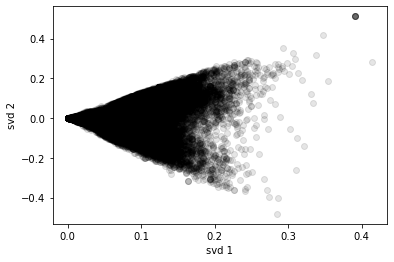

In [19]:
svd_components = pd.DataFrame(X)

plt.scatter(svd_components[0], svd_components[1], alpha=.1, color='black')
plt.xlabel('svd 1')
plt.ylabel('svd 2')
plt.show()

Looking at the first two features from the SVD does not show much separation in the data. From here, we can gather that there may be at least two clusters. However, plotting the second and third feature shows more information.

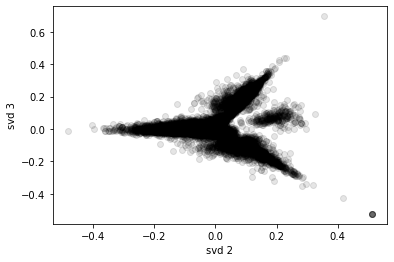

In [53]:
svd_components = pd.DataFrame(X)

plt.scatter(svd_components[1], svd_components[2], alpha=.1, color='black')
plt.xlabel('svd 2')
plt.ylabel('svd 3')
plt.show()

Here, the clusters are more visible, and we should acquire at least 4 different clusters.

The total explained variance from SVD: 14.239%


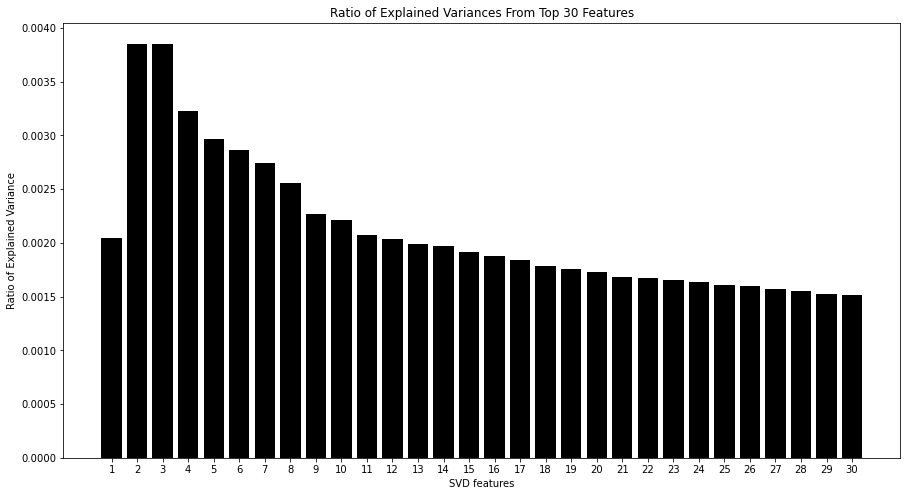

In [20]:
print(f"The total explained variance from SVD: {svd.explained_variance_ratio_.sum() * 100:.3f}%")

features = range(1, 31)
plt.figure(figsize=(15, 8))
plt.bar(features, svd.explained_variance_ratio_[:30], color='black')
plt.xlabel('SVD features')
plt.ylabel('Ratio of Explained Variance')
plt.title("Ratio of Explained Variances From Top 30 Features")
plt.xticks(features)
plt.show()

Using 100 components from the SVD results in 14.239% of the variance being explained in the data. A small proportion of the variance explained is expected because the matrix is very sparse, as mentioned previously that only 0.1% of the elements being nonzero. Although 100 components still results in a very low proportion of the variance to be explained, the model will be trained on the top 3 SVD features to visualize the data.

## Processing Dataset Using K-means Clustering

In this portion, we will train a K-means clustering model. To determine the number of clusters that will be used in the model, we use the Elbow method. A plot of the amount of inertia generated for a given number of clusters will be generated. The plot will show the intercluster variance for a given k because inertia is the within-cluster sum of squared distances. The number of clusters is decided by choosing the value in which there is diminishing returns in terms of the amount of variance captured (Saji).

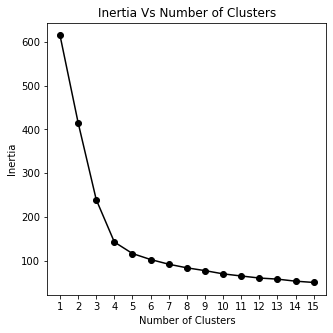

In [21]:
# Determine the Amount of Inertia for each K
k_vals = range(1, 16)
inertias = []
scores = []
for k in k_vals:
    km_model = KMeans(n_clusters=k, max_iter=100, n_init=5, init = 'k-means++')
    km_model.fit(X[:, :3])
    
    # Append the inertia to the list of inertias
    inertias.append(km_model.inertia_)
    
    
plt.figure(figsize=(5, 5))    
plt.plot(k_vals, inertias, '-o', color='black')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title("Inertia Vs Number of Clusters")
plt.xticks(k_vals)
plt.show()

Since the elbow is at about 4 clusters, k will be chosen as 4.

In [54]:
km_model = KMeans(n_clusters=4, max_iter=100, n_init=5, init = 'k-means++')
km_model.fit(X)

KMeans(max_iter=100, n_clusters=4, n_init=5)

In [55]:
original_space_centroids = svd.inverse_transform(km_model.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(4):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :15]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: rt health ebola may study cancer says get yous help nhs care drug video patients 
Cluster 1: well ask cancer doctor exercise living think may like tied workout health heart doctors new 
Cluster 2: new old blog age york study health rt ebola rules year finds care nhs drug 
Cluster 3: risk may cancer study heart higher raise lower stroke linked diabetes breast disease death tied 


In [56]:
clusters = km_model.labels_

tweet_df_labeled = tweet_df_processed.copy()
tweet_df_labeled['x1'] = X[:, 0]
tweet_df_labeled['x2'] = X[:, 1]
tweet_df_labeled['x3'] = X[:, 2]
tweet_df_labeled['cluster'] = clusters

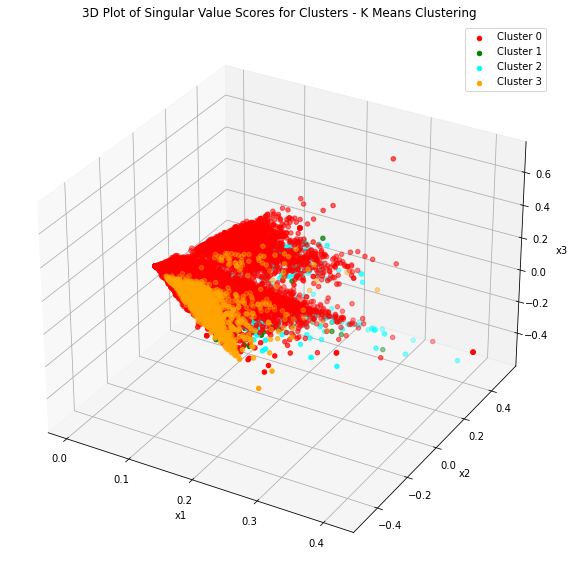

In [58]:
fig = plt.figure(figsize=(10, 10))

s_plot = fig.add_subplot(111, projection='3d')

colors = ['red', 'green', 'cyan', 'orange', 'yellow']

for i in range(4):
    c = tweet_df_labeled[tweet_df_labeled['cluster'] == i]
    s_plot.scatter(c['x1'], c['x2'], c['x3'], label=f"Cluster {i}", c=colors[i])

s_plot.legend()
s_plot.set_xlabel("x1")
s_plot.set_ylabel("x2")
s_plot.set_zlabel("x3")
s_plot.set_title("3D Plot of Singular Value Scores for Clusters - K Means Clustering")

plt.show()

In this plot, we can see that there is significant overlap in the clusters.

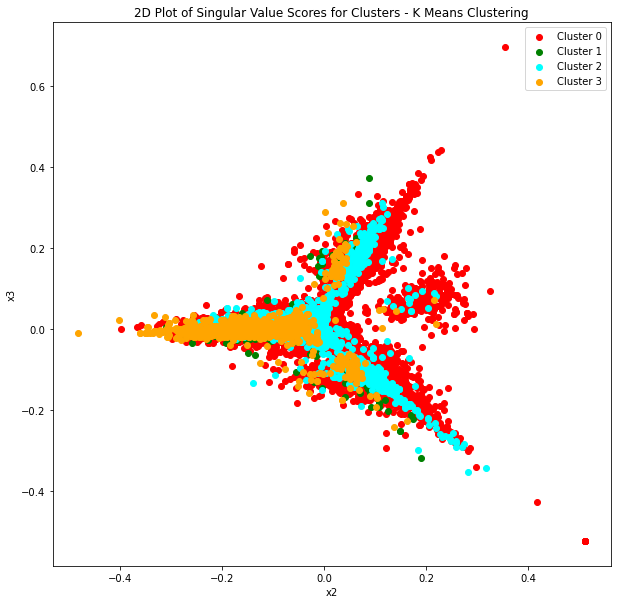

In [59]:
fig = plt.figure(figsize=(10, 10))

s_plot = fig.add_subplot(111)

colors = ['red', 'green', 'cyan', 'orange', 'yellow']

for i in range(4):
    c = tweet_df_labeled[tweet_df_labeled['cluster'] == i]
    s_plot.scatter(c['x2'], c['x3'], label=f"Cluster {i}", c=colors[i])

s_plot.legend()
s_plot.set_xlabel("x2")
s_plot.set_ylabel("x3")
s_plot.set_title("2D Plot of Singular Value Scores for Clusters - K Means Clustering")

plt.show()

## Processing Dataset using Mean-Shift Clustering

In this portion, we will train a Mean-Shift Clustering model. This algorithm is nonparametric, and so it does not need the number of clusters specified. Mean-Shift is another centroid based algorithm that iteratively shifts each point toward the weighted center.

In [62]:
ms = MeanShift(bin_seeding=True)
ms.fit(X[:, :3])
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 11


The number of estimated clusters that were determined from the Mean-Shift model ended up being significantly more than K-Means.

In [63]:
tweet_df_ms = tweet_df_labeled.copy()
tweet_df_ms['cluster'] = labels

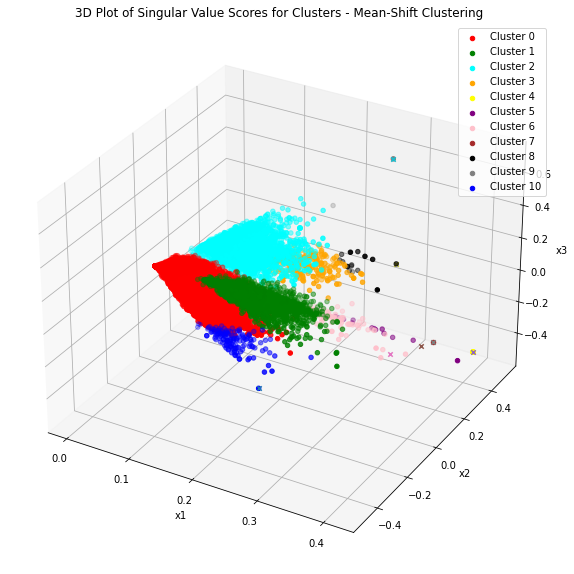

In [64]:
colors = ['red', 'green', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 'gray', 'blue']

fig = plt.figure(figsize=(10, 10))

s_plot = fig.add_subplot(111, projection='3d')

for k, col in zip(range(n_clusters_), colors):
    c = tweet_df_ms[tweet_df_ms['cluster'] == k]
    cluster_center = cluster_centers[k]
    s_plot.scatter(c['x1'], c['x2'], c['x3'], c=colors[k], label=f"Cluster {k}")
    s_plot.scatter(
        cluster_center[0],
        cluster_center[1],
        cluster_center[2],
        marker='x',
    )
    
s_plot.legend()
s_plot.set_xlabel("x1")
s_plot.set_ylabel("x2")
s_plot.set_zlabel("x3")
plt.title("3D Plot of Singular Value Scores for Clusters - Mean-Shift Clustering")
plt.show()

In this iteration using the Mean-Shift model, the clusters are better defined and separated.

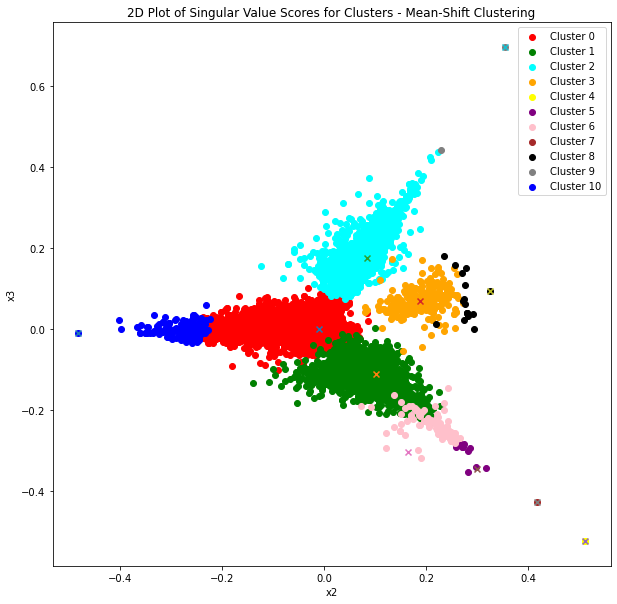

In [66]:
fig = plt.figure(figsize=(10, 10))

s_plot = fig.add_subplot(111)

for k, col in zip(range(n_clusters_), colors):
    c = tweet_df_labeled[tweet_df_ms['cluster'] == k]
    cluster_center = cluster_centers[k]
    s_plot.scatter(c['x2'], c['x3'], c=colors[k], label=f"Cluster {k}")
    s_plot.scatter(
        cluster_center[1],
        cluster_center[2],
        marker='x',
    )
    
s_plot.legend()
s_plot.set_xlabel("x2")
s_plot.set_ylabel("x3")
plt.title("2D Plot of Singular Value Scores for Clusters - Mean-Shift Clustering")
plt.show()

Looking at the singular value scores from the x2-x3 perspective, we can see very clearly the different clusters. They are better defined with this model. 

## Comparison of the Two Methods

In regards to computational complexity, the Mean-Shift clustering algorithm took significantly longer than K-Means to fit on the data. Training the model on the data required several minutes at a time, whereas K-Means finished in under a minute. However, there was no need for anything like cross validation for Mean-Shift since it is nonparametric and determines the number of clusters through the algorithm itself.

In [67]:
metrics.silhouette_score(X[:, :3], ms.labels_)

0.6345106777237226

In [68]:
metrics.silhouette_score(X[:, :3], km_model.labels_)

0.09200567473460551

The Silhouette score is a metric used to evaluate the performance of a clustering model. The score explains how well samples were assigned to clusters, or in other words, how similar a sample is to the others in its cluster. The score can range from -1 to 1. Values close to 1 indicate that the clusters are well defined and separated. However, values closer to 0 indicate multiple overlapping clusters, and those values closer to -1 indicate incorrect assignment to clusters. 

Here we can see that the score for Mean-Shift is about 7 times larger than the score for K-Means, thereby implying the clusters that resulted from Mean-Shift were more defined and separated than K-means. Plotting the two models and their cluster labels side by side makes this evident.

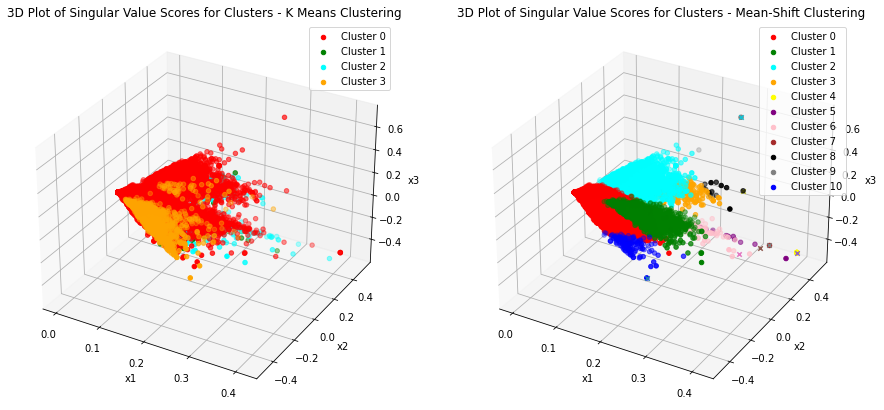

In [70]:
fig = plt.figure(figsize=(15, 15))

km_plot = fig.add_subplot(121, projection='3d')

colors_km = ['red', 'green', 'cyan', 'orange', 'yellow']

for i in range(4):
    c = tweet_df_labeled[tweet_df_labeled['cluster'] == i]
    km_plot.scatter(c['x1'], c['x2'], c['x3'], label=f"Cluster {i}", c=colors_km[i])

km_plot.legend()
km_plot.set_xlabel("x1")
km_plot.set_ylabel("x2")
km_plot.set_zlabel("x3")
km_plot.set_title("3D Plot of Singular Value Scores for Clusters - K Means Clustering")

colors_ms = ['red', 'green', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 'gray', 'blue']

ms_plot = fig.add_subplot(122, projection='3d')

for k, col in zip(range(n_clusters_), colors_ms):
    c = tweet_df_ms[tweet_df_ms['cluster'] == k]
    cluster_center = cluster_centers[k]
    ms_plot.scatter(c['x1'], c['x2'], c['x3'], c=col, label=f"Cluster {k}")
    ms_plot.scatter(
        cluster_center[0],
        cluster_center[1],
        cluster_center[2],
        marker='x',
    )
    
ms_plot.legend()
ms_plot.set_xlabel("x1")
ms_plot.set_ylabel("x2")
ms_plot.set_zlabel("x3")
ms_plot.set_title("3D Plot of Singular Value Scores for Clusters - Mean-Shift Clustering")
plt.show()

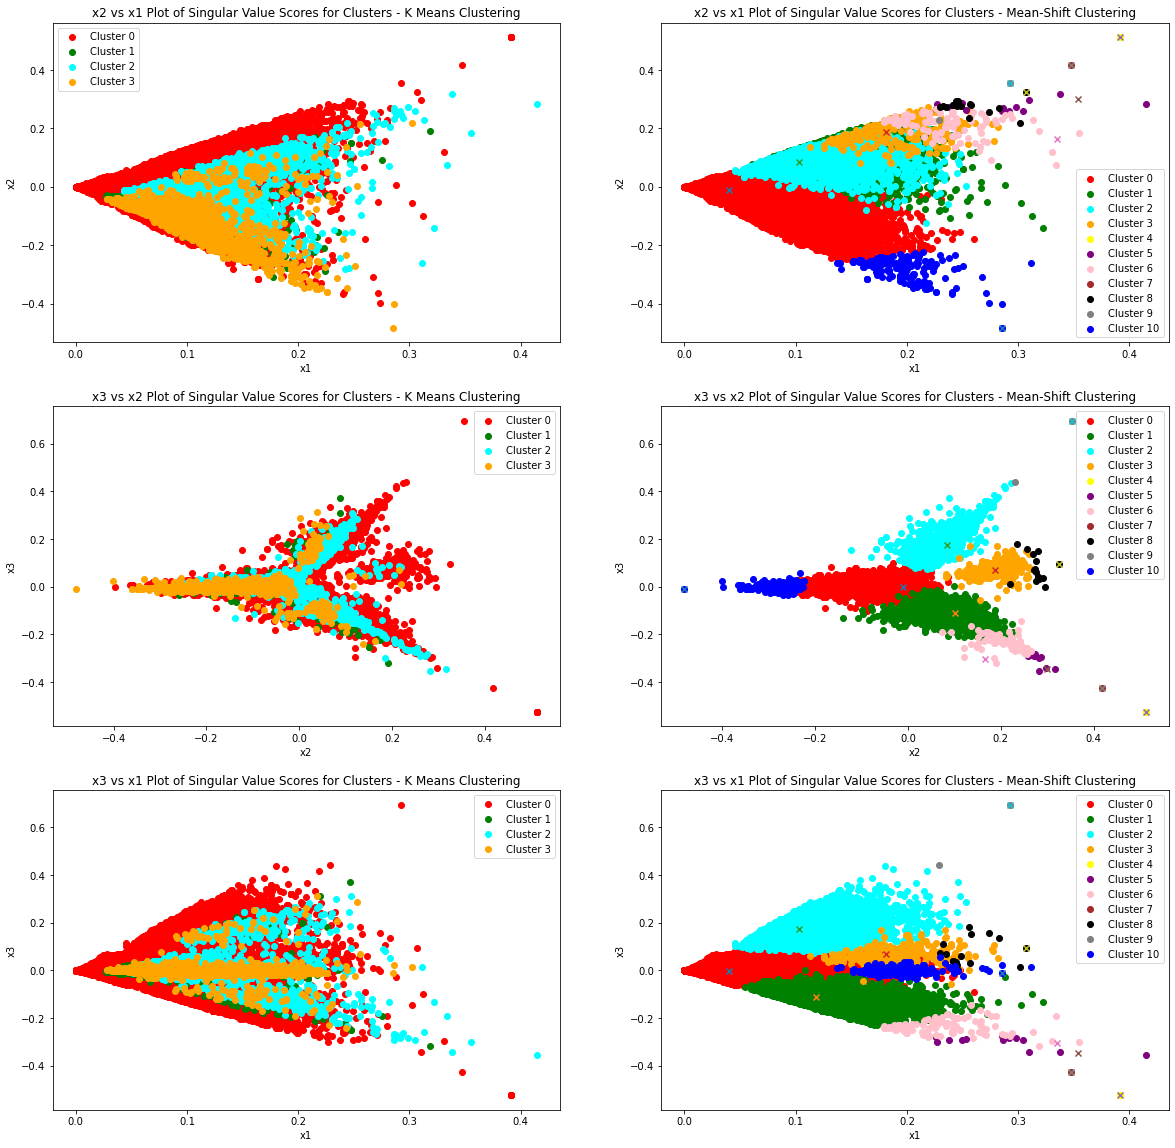

In [73]:
fig = plt.figure(figsize=(20, 20))

km_plot1 = fig.add_subplot(321)
ms_plot1 = fig.add_subplot(322)
km_plot2 = fig.add_subplot(323)
ms_plot2 = fig.add_subplot(324)
km_plot3 = fig.add_subplot(325)
ms_plot3 = fig.add_subplot(326)

for i in range(4):
    c = tweet_df_labeled[tweet_df_labeled['cluster'] == i]
    km_plot1.scatter(c['x1'], c['x2'], label=f"Cluster {i}", c=colors_km[i])
    km_plot2.scatter(c['x2'], c['x3'], label=f"Cluster {i}", c=colors_km[i])
    km_plot3.scatter(c['x1'], c['x3'], label=f"Cluster {i}", c=colors_km[i])

km_plot1.legend()
km_plot1.set_xlabel("x1")
km_plot1.set_ylabel("x2")
km_plot1.set_title("x2 vs x1 Plot of Singular Value Scores for Clusters - K Means Clustering")

km_plot2.legend()
km_plot2.set_xlabel("x2")
km_plot2.set_ylabel("x3")
km_plot2.set_title("x3 vs x2 Plot of Singular Value Scores for Clusters - K Means Clustering")

km_plot3.legend()
km_plot3.set_xlabel("x1")
km_plot3.set_ylabel("x3")
km_plot3.set_title("x3 vs x1 Plot of Singular Value Scores for Clusters - K Means Clustering")

for k, col in zip(range(n_clusters_), colors_ms):
    c = tweet_df_labeled[tweet_df_ms['cluster'] == k]
    cluster_center = cluster_centers[k]
    ms_plot1.scatter(c['x1'], c['x2'], c=col, label=f"Cluster {k}")
    ms_plot1.scatter(
        cluster_center[0],
        cluster_center[1],
        marker='x',
    )
    ms_plot2.scatter(c['x2'], c['x3'], c=col, label=f"Cluster {k}")
    ms_plot2.scatter(
        cluster_center[1],
        cluster_center[2],
        marker='x',
    )
    ms_plot3.scatter(c['x1'], c['x3'], c=col, label=f"Cluster {k}")
    ms_plot3.scatter(
        cluster_center[0],
        cluster_center[2],
        marker='x',
    )
    
ms_plot1.legend()
ms_plot1.set_xlabel("x1")
ms_plot1.set_ylabel("x2")
ms_plot1.set_title("x2 vs x1 Plot of Singular Value Scores for Clusters - Mean-Shift Clustering")

ms_plot2.legend()
ms_plot2.set_xlabel("x2")
ms_plot2.set_ylabel("x3")
ms_plot2.set_title("x3 vs x2 Plot of Singular Value Scores for Clusters - Mean-Shift Clustering")

ms_plot3.legend()
ms_plot3.set_xlabel("x1")
ms_plot3.set_ylabel("x3")
ms_plot3.set_title("x3 vs x1 Plot of Singular Value Scores for Clusters - Mean-Shift Clustering")

plt.show()

From every perspective, the Mean-Shift model resulted in significantly less overlap and better defined clusters. These visualizations capture the difference in the Silhouette scores, as the K-Means model with a lower Silhouette score performed worse than the Mean-Shift model. As a result, despite the longer training time for Mean-Shift, it is the model that should be in a production system.

## Ethical Issues

There was nothing unethical about the way the data was collected. Tweets are open to the public, and this dataset was compiled by taking a large number of tweets from health news agencies (Karami). However, in regards to the machine learning task of clustering together tweets that have to do with similar health topics, there may be an ethical dilemma. The model can be used to group together similar tweets and thereby provide the user with tweets that may be relevant to what they are currently looking at. Although this is fine and can be helpful at a surface level, it poses an issue when companies use this to keep users on Twitter and endlessly browse through different tweets, and thereby increase ad revenue. It is unethical to selfishly use these machine learning methods to keep users on a platform to generate the most amount of money. 

## Bibliography

Karami, Amir. “Health News in Twitter Data Set.” UCI Machine Learning Repository, https://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter#. 

Kaushik, Sauravkaushik. “Clustering: Types of Clustering: Clustering Applications.” Analytics Vidhya, 29 Nov. 2022, https://www.analyticsvidhya.com/blog/2016/11/an-introduction-to-clustering-and-different-methods-of-clustering/. 

Lin, Jianan. “Understanding Mean Shift Clustering and Implementation with Python.” Medium, Towards Data Science, 22 Feb. 2022, https://towardsdatascience.com/understanding-mean-shift-clustering-and-implementation-with-python-6d5809a2ac40. 

Prettenhofer, Peter, et al. “Clustering Text Documents Using K-Means.” Scikit-Learn, https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html. 

Saji, Basil. “K Means Clustering: K Means Clustering Algorithm in Machine Learning.” Analytics Vidhya, 5 Dec. 2022, https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/.

scikit-learn developers. “A Demo of the Mean-Shift Clustering Algorithm.” Scikit-Learn, https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html#sphx-glr-auto-examples-cluster-plot-mean-shift-py.

---. “Sklearn.cluster.kmeans.” Scikit-Learn, https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans. 

---. “Sklearn.cluster.MeanShift.” Scikit-Learn, https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift. 

---. “Sklearn.metrics.silhouette_score.” Scikit-Learn, https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html. 

Simha, Anirudha. “Understanding TF-IDF for Machine Learning.” Capital One, 6 Oct. 2021, https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/. 